In [458]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [459]:
mem_usage_df = pd.DataFrame(pd.read_csv("./datasets/memory_usage.csv")["mem_usage"])
cpu_usage_df = pd.DataFrame(pd.read_csv("./datasets/cpu_usage.csv")["cpu_usage"])

In [460]:
usage_df = pd.concat([mem_usage_df, cpu_usage_df], axis=1)

In [461]:
usage_df.describe()

,mem_usage,cpu_usage
count,1.111000e+03,1111.000000
mean,7.123128e+06,0.008101
std,9.949669e+05,0.004616
min,5.050368e+06,0.001054
25%,7.352320e+06,0.003012
50%,7.528448e+06,0.008684
75%,7.757824e+06,0.011573
max,7.999488e+06,0.018026


In [462]:
scaler = StandardScaler()
scaler.fit(usage_df)
usage_df = scaler.transform(usage_df)

In [478]:
pd.DataFrame(usage_df).head()

,0,1
0,-1.989457,-1.409124
1,-1.989457,-1.411753
2,-1.989457,-1.411753
3,-1.989457,-1.411753
4,-1.989457,-1.416867


In [463]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [464]:
# specify the number of lag hours
n_cycles = 3
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(usage_df, n_cycles, 1)

In [465]:
reframed

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,-1.989457,-1.409124,-1.989457,-1.411753,-1.989457,-1.411753,-1.989457,-1.411753
4,-1.989457,-1.411753,-1.989457,-1.411753,-1.989457,-1.411753,-1.989457,-1.416867
5,-1.989457,-1.411753,-1.989457,-1.411753,-1.989457,-1.416867,-1.989457,-1.416867
6,-1.989457,-1.411753,-1.989457,-1.416867,-1.989457,-1.416867,-1.989457,-1.416867
7,-1.989457,-1.416867,-1.989457,-1.416867,-1.989457,-1.416867,-1.989457,-1.416867
...,...,...,...,...,...,...,...,...
1106,0.745277,-0.252471,0.745277,-0.252471,0.745277,-0.252471,0.745277,-0.516532
1107,0.745277,-0.252471,0.745277,-0.252471,0.745277,-0.516532,0.745277,-0.442634
1108,0.745277,-0.252471,0.745277,-0.516532,0.745277,-0.442634,0.745277,-0.527063
1109,0.745277,-0.516532,0.745277,-0.442634,0.745277,-0.527063,0.745277,-0.611491


In [466]:
split_count = math.floor(len(reframed) * 0.67)
values = reframed.values

train = values[:split_count, :]
test = values[split_count:, :]

In [467]:
# split into input and outputs
n_obs = n_cycles * n_features
train_X, train_y = train[:, :n_obs], train[:,-n_features:]
test_X, test_y = test[:, :n_obs], test[:, -n_features:]
print(train_X.shape, len(train_X), train_y.shape)

(742, 6) 742 (742, 2)


In [468]:
train_X = train_X.reshape((train_X.shape[0], n_cycles, n_features))
test_X = test_X.reshape((test_X.shape[0], n_cycles, n_features))

In [483]:
from math import sqrt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Epoch 1/50
11/11 - 2s - loss: 0.9660 - val_loss: 0.5887 - 2s/epoch - 225ms/step
Epoch 2/50
11/11 - 0s - loss: 0.8068 - val_loss: 0.4970 - 92ms/epoch - 8ms/step
Epoch 3/50
11/11 - 0s - loss: 0.6521 - val_loss: 0.3995 - 88ms/epoch - 8ms/step
Epoch 4/50
11/11 - 0s - loss: 0.4765 - val_loss: 0.2979 - 70ms/epoch - 6ms/step
Epoch 5/50
11/11 - 0s - loss: 0.2896 - val_loss: 0.2441 - 93ms/epoch - 8ms/step
Epoch 6/50
11/11 - 0s - loss: 0.2551 - val_loss: 0.2356 - 69ms/epoch - 6ms/step
Epoch 7/50
11/11 - 0s - loss: 0.2105 - val_loss: 0.2262 - 80ms/epoch - 7ms/step
Epoch 8/50
11/11 - 0s - loss: 0.1834 - val_loss: 0.2095 - 71ms/epoch - 6ms/step
Epoch 9/50
11/11 - 0s - loss: 0.1674 - val_loss: 0.2045 - 74ms/epoch - 7ms/step
Epoch 10/50
11/11 - 0s - loss: 0.1651 - val_loss: 0.1826 - 74ms/epoch - 7ms/step
Epoch 11/50
11/11 - 0s - loss: 0.1607 - val_loss: 0.1784 - 72ms/epoch - 7ms/step
Epoch 12/50
11/11 - 0s - loss: 0.1468 - val_loss: 0.1644 - 68ms/epoch - 6ms/step
Epoch 13/50
11/11 - 0s - loss: 0.1217

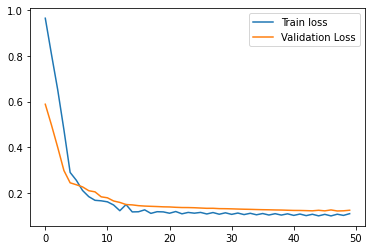

In [470]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='Train loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.show()

In [480]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 64)                17152     
                                                                 
 dense_27 (Dense)            (None, 2)                 130       
                                                                 
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________


In [475]:
import visualkeras
visualkeras.layered_view(model).show()

In [471]:
# make a prediction
yhat = model.predict(test_X)

12/12 [==============================] - 0s 1ms/step


In [472]:
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

In [484]:
mse_mem = mean_squared_error(inv_y[:,0], inv_yhat[:,0])
mae_mem = mean_absolute_error(inv_y[:,0], inv_yhat[:,0])
rmse_mem = sqrt(mse_mem)

print("mean_absolut_error", mae_mem)
print("mean_squared_error", mse_mem)
print("root_mean_squared_error", rmse_mem)



mean_absolut_error 50345.6543715847
mean_squared_error 23849780552.629097
root_mean_squared_error 154433.74162607436


In [485]:
mse_cpu = mean_squared_error(inv_y[:,1], inv_yhat[:,1])
mae_cpu = mean_absolute_error(inv_y[:,1], inv_yhat[:,1])
rmse_cpu = sqrt(mse_cpu)

print("mean_absolut_error", mae_cpu)
print("mean_squared_error", mse_cpu)
print("root_mean_squared_error", rmse_cpu)



mean_absolut_error 0.0009084099362412646
mean_squared_error 1.4697250697495431e-06
root_mean_squared_error 0.0012123221806720947


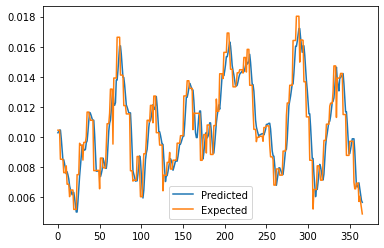

In [488]:
pyplot.plot(inv_yhat[:,1], label='Predicted')
pyplot.plot(inv_y[:,1], label='Expected')
pyplot.legend()
pyplot.show()